In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

In [2]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")


In [3]:
file_path = r"E:/sagemaker-flight_price/data/train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,21-03-2019,Banglore,New Delhi,08:55:00,19:10:00,615,1,In-flight meal not included,7832
1,Jet Airways,27-03-2019,Delhi,Cochin,17:30:00,04:25:00,655,1,In-flight meal not included,6540
2,Goair,09-03-2019,Banglore,New Delhi,11:40:00,14:35:00,175,0,No Info,7305
3,Air India,12-06-2019,Kolkata,Banglore,09:25:00,18:30:00,545,1,No Info,8366
4,Jet Airways,12-03-2019,Banglore,New Delhi,22:55:00,07:40:00,525,1,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,21-03-2019,Delhi,Cochin,10:45:00,18:50:00,1925,2,No Info,11093
6691,Air India,01-05-2019,Kolkata,Banglore,09:25:00,18:30:00,545,1,No Info,8891
6692,Jet Airways,01-06-2019,Delhi,Cochin,14:00:00,19:00:00,300,1,In-flight meal not included,10262
6693,Air Asia,24-06-2019,Delhi,Cochin,07:55:00,13:25:00,330,1,No Info,6152


In [4]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          6695 non-null   object
 1   date_of_journey  6695 non-null   object
 2   source           6695 non-null   object
 3   destination      6695 non-null   object
 4   dep_time         6695 non-null   object
 5   arrival_time     6695 non-null   object
 6   duration         6695 non-null   int64 
 7   total_stops      6695 non-null   int64 
 8   additional_info  6695 non-null   object
 9   price            6695 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 523.2+ KB


In [5]:

X_train = train.drop(columns="price")
y_train = train.price.copy()

### Airline

In [6]:
X_train.airline


0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6695, dtype: object

In [7]:

air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0
6691,1.0,0.0,0.0,0.0,0.0
6692,0.0,0.0,1.0,0.0,0.0
6693,0.0,0.0,0.0,0.0,1.0


### Date of journey

In [8]:
X_train.date_of_journey


0       21-03-2019
1       27-03-2019
2       09-03-2019
3       12-06-2019
4       12-03-2019
           ...    
6690    21-03-2019
6691    01-05-2019
6692    01-06-2019
6693    24-06-2019
6694    01-03-2019
Name: date_of_journey, Length: 6695, dtype: object

In [9]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.181818,0.229167,0.500000,0.228487
1,0.181818,0.250000,0.333333,0.246291
2,0.727273,0.729167,0.166667,0.721068
3,1.000000,1.000000,0.666667,1.000000
4,1.000000,1.000000,0.166667,0.991098
...,...,...,...,...
6690,0.181818,0.229167,0.500000,0.228487
6691,0.000000,0.000000,0.833333,0.005935
6692,0.000000,0.000000,1.000000,0.008902
6693,0.454545,0.520833,0.000000,0.510386


### Source and Destination

In [10]:
X_train.source


0       Banglore
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6690       Delhi
6691     Kolkata
6692       Delhi
6693       Delhi
6694    Banglore
Name: source, Length: 6695, dtype: object

In [11]:
X_train.destination


0       New Delhi
1          Cochin
2       New Delhi
3        Banglore
4       New Delhi
          ...    
6690       Cochin
6691     Banglore
6692       Cochin
6693       Cochin
6694    New Delhi
Name: destination, Length: 6695, dtype: object

In [12]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Banglore,New Delhi
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Banglore,New Delhi
...,...,...
6690,Delhi,Cochin
6691,Kolkata,Banglore
6692,Delhi,Cochin
6693,Delhi,Cochin


In [13]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.857930,-0.736484
1,1.065418,1.061694
2,-0.857930,-0.736484
3,-0.203928,-0.224351
4,-0.857930,-0.736484
...,...,...
6690,1.065418,1.061694
6691,-0.203928,-0.224351
6692,1.065418,1.061694
6693,1.065418,1.061694


In [14]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [15]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
6690,1,0
6691,1,0
6692,1,0
6693,1,0


In [16]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.857930,-0.736484,0,1
1,1.065418,1.061694,1,0
2,-0.857930,-0.736484,0,1
3,-0.203928,-0.224351,1,0
4,-0.857930,-0.736484,0,1
...,...,...,...,...
6690,1.065418,1.061694,1,0
6691,-0.203928,-0.224351,1,0
6692,1.065418,1.061694,1,0
6693,1.065418,1.061694,1,0


### Dep_time and Arrival_time

In [17]:
X_train.dep_time


0       08:55:00
1       17:30:00
2       11:40:00
3       09:25:00
4       22:55:00
          ...   
6690    10:45:00
6691    09:25:00
6692    14:00:00
6693    07:55:00
6694    11:50:00
Name: dep_time, Length: 6695, dtype: object

In [18]:
X_train.arrival_time


0       19:10:00
1       04:25:00
2       14:35:00
3       18:30:00
4       07:40:00
          ...   
6690    18:50:00
6691    18:30:00
6692    19:00:00
6693    13:25:00
6694    08:55:00
Name: arrival_time, Length: 6695, dtype: object

In [19]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,08:55:00,19:10:00
1,17:30:00,04:25:00
2,11:40:00,14:35:00
3,09:25:00,18:30:00
4,22:55:00,07:40:00
...,...,...
6690,10:45:00,18:50:00
6691,09:25:00,18:30:00
6692,14:00:00,19:00:00
6693,07:55:00,13:25:00


In [20]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,1.000000,0.826087,0.181818
1,0.739130,0.545455,0.173913,0.454545
2,0.478261,0.727273,0.608696,0.636364
3,0.391304,0.454545,0.782609,0.545455
4,0.956522,1.000000,0.304348,0.727273
...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091
6691,0.391304,0.454545,0.782609,0.545455
6692,0.608696,0.000000,0.826087,0.000000
6693,0.304348,1.000000,0.565217,0.454545


In [21]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,evening,morning
2,morning,afternoon
3,morning,evening
4,night,morning
...,...,...
6690,morning,evening
6691,morning,evening
6692,afternoon,evening
6693,morning,afternoon


In [22]:

time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.667335
1,0.202685,0.952906
2,1.000000,0.000000
3,1.000000,0.667335
4,0.174101,0.952906
...,...,...
6690,1.000000,0.667335
6691,1.000000,0.667335
6692,0.000000,0.667335
6693,1.000000,0.000000


In [23]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335
1,0.739130,0.545455,0.173913,0.454545,0.202685,0.952906
2,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000
3,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
4,0.956522,1.000000,0.304348,0.727273,0.174101,0.952906
...,...,...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335
6691,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
6692,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335
6693,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


### Duration

In [24]:
X_train.duration


0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6695, dtype: int64

In [25]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[170. ],
       [510. ],
       [922.5]])

In [26]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)


In [27]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)


,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,1.000000,1.000000
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,0.904837,0.904837
3,0.000000e+00,0.0,1.000000,1.000000
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
6690,0.000000e+00,0.0,0.904837,0.904837
6691,0.000000e+00,0.0,1.000000,1.000000
6692,4.225900e-132,0.0,1.000000,1.000000
6693,7.187782e-28,0.0,1.000000,1.000000


In [28]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [29]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [30]:

duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.364262,-0.107976,-0.107799,2.0,0,-0.033916
1,-0.364262,-0.107976,-0.107799,2.0,0,0.046422
2,2.373008,-0.107976,-0.107799,0.0,0,-0.917631
3,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507
4,-0.364262,-0.107975,-0.107799,2.0,0,-0.214676
...,...,...,...,...,...,...
6690,-0.364262,-0.107976,-0.107799,2.0,1,2.597145
6691,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507
6692,-0.364262,-0.107976,-0.107799,1.0,0,-0.666576
6693,-0.364262,-0.107976,-0.107799,1.0,0,-0.606322


### Total_stops

In [31]:
X_train.total_stops


0       1
1       1
2       0
3       1
4       1
       ..
6690    2
6691    1
6692    1
6693    1
6694    1
Name: total_stops, Length: 6695, dtype: int64

In [32]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
6690,2,0
6691,1,0
6692,1,0
6693,1,0


### Additional_Info

In [33]:
X_train.additional_info


0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6690                        No Info
6691                        No Info
6692    In-flight meal not included
6693                        No Info
6694                 1 Long layover
Name: additional_info, Length: 6695, dtype: object

In [34]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,1.0,0.0,0.0
6693,0.0,1.0,0.0


In [35]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))


In [36]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [37]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,1.0,0.0,0.0,1
6693,0.0,1.0,0.0,0


### Column Transformer

In [38]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.181818,0.229167,0.500000,0.228487,-0.857930,-0.736484,0,1,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,0,-0.033916,1,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.181818,0.250000,0.333333,0.246291,1.065418,1.061694,1,0,0.739130,0.545455,0.173913,0.454545,0.202685,0.952906,-0.364262,-0.107976,-0.107799,2.0,0,0.046422,1,0,1.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,0.727273,0.729167,0.166667,0.721068,-0.857930,-0.736484,0,1,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000,2.373008,-0.107976,-0.107799,0.0,0,-0.917631,0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.666667,1.000000,-0.203928,-0.224351,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507,1,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,0.166667,0.991098,-0.857930,-0.736484,0,1,0.956522,1.000000,0.304348,0.727273,0.174101,0.952906,-0.364262,-0.107975,-0.107799,2.0,0,-0.214676,1,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0,0.181818,0.229167,0.500000,0.228487,1.065418,1.061694,1,0,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,1,2.597145,2,0,0.0,1.0,0.0,0
6691,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.833333,0.005935,-0.203928,-0.224351,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507,1,0,0.0,1.0,0.0,0
6692,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.008902,1.065418,1.061694,1,0,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335,-0.364262,-0.107976,-0.107799,1.0,0,-0.666576,1,0,1.0,0.0,0.0,1
6693,0.0,0.0,0.0,0.0,1.0,0.454545,0.520833,0.000000,0.510386,1.065418,1.061694,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.364262,-0.107976,-0.107799,1.0,0,-0.606322,1,0,0.0,1.0,0.0,0


In [39]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

### Putting everything together

In [40]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.228487,-0.857930,-0.736484,-0.364262,2.0,0,-0.033916,1,0
1,0.0,1.0,0.0,0.246291,1.065418,1.061694,-0.364262,2.0,0,0.046422,1,0
2,0.0,0.0,1.0,0.721068,-0.857930,-0.736484,2.373008,0.0,0,-0.917631,0,1
3,0.0,0.0,0.0,1.000000,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1,0
4,0.0,1.0,0.0,0.991098,-0.857930,-0.736484,-0.364262,2.0,0,-0.214676,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,1.0,0.0,0.228487,1.065418,1.061694,-0.364262,2.0,1,2.597145,2,0
6691,0.0,0.0,0.0,0.005935,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1,0
6692,0.0,1.0,0.0,0.008902,1.065418,1.061694,-0.364262,1.0,0,-0.666576,1,0
6693,0.0,0.0,1.0,0.510386,1.065418,1.061694,-0.364262,1.0,0,-0.606322,1,0


### Visualization

In [41]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances


{'air__airline_Air India': np.float64(0.0016858488187393068),
 'air__airline_Indigo': np.float64(0.12827620333701603),
 'air__airline_Jet Airways': np.float64(0.19341654864699923),
 'air__airline_Multiple Carriers': np.float64(0.01885367626900632),
 'air__airline_Other': np.float64(0.11819934849670959),
 'doj__date_of_journey_month': np.float64(0.043446198265843505),
 'doj__date_of_journey_week': np.float64(0.07139579653179877),
 'doj__date_of_journey_day_of_week': np.float64(0.01514621965273085),
 'doj__date_of_journey_day_of_year': np.float64(0.15146416909119428),
 'location__source': np.float64(0.1267120700518518),
 'location__destination': np.float64(0.13064205945980614),
 'location__source_is_north': np.float64(0.029331367522183977),
 'location__destination_is_north': np.float64(0.029331367522183977),
 'time__dep_time_hour': np.float64(0.007541502467654985),
 'time__dep_time_minute': np.float64(0.03749304101660215),
 'time__arrival_time_hour': np.float64(0.07867962012854395),
 'ti

In [42]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp


{'time__dep_time_part_of_day': np.float64(-0.0013166458315723162),
 'info__additional_info_No Info': np.float64(-0.001132211161403977),
 'info__additional_info': np.float64(-0.001132211161403977),
 'dur__duration_rbf_75': np.float64(0.0007341117000158048),
 'info__additional_info_In-flight meal not included': np.float64(0.0014426619953507396),
 'air__airline_Air India': np.float64(0.0016858488187393068),
 'dur__duration_rbf_50': np.float64(0.005915259152939482),
 'time__dep_time_hour': np.float64(0.007541502467654985),
 'doj__date_of_journey_day_of_week': np.float64(0.01514621965273085),
 'info__additional_info_Other': np.float64(0.01760748529752132),
 'air__airline_Multiple Carriers': np.float64(0.01885367626900632),
 'location__source_is_north': np.float64(0.029331367522183977),
 'location__destination_is_north': np.float64(0.029331367522183977),
 'time__arrival_time_part_of_day': np.float64(0.0313709099091218),
 'time__arrival_time_minute': np.float64(0.03229609256720356),
 'time__d

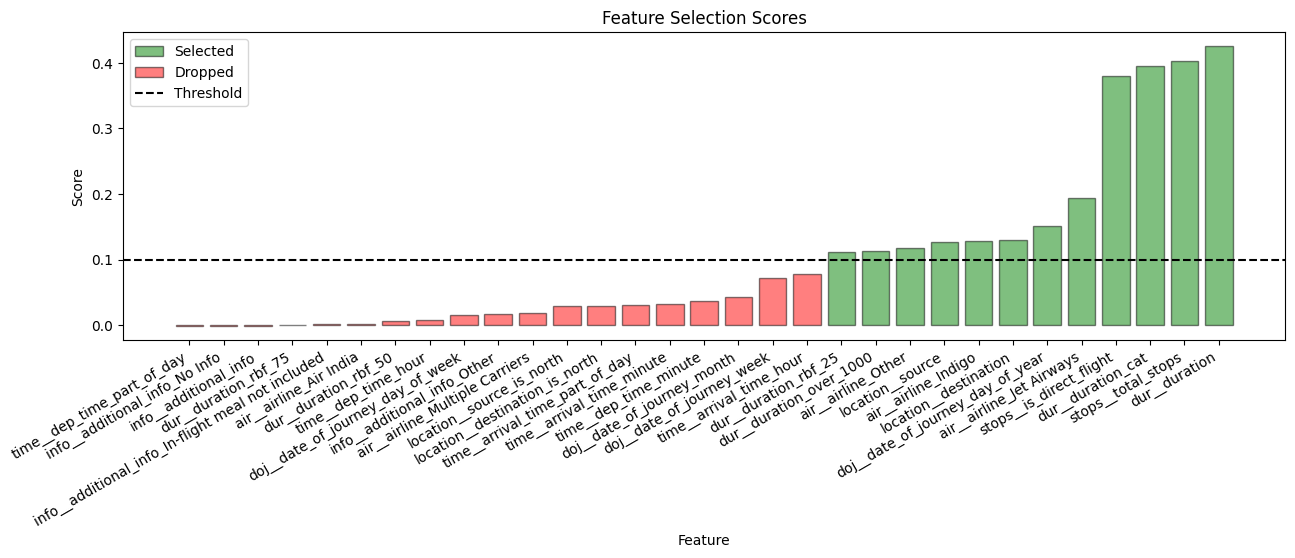

In [43]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()


- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that